<a href="https://colab.research.google.com/github/FMagnani/Physics_Informed_NeuralNetwork/blob/main/Schrodinger_Discrete/TF2_Schrodinger_Discrete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

Cloning GitHub repo 

In [ ]:
!git clone https://github.com/FMagnani/Physics_Informed_NeuralNetwork.git

Cloning into 'Physics_Informed_NeuralNetwork'...
remote: Enumerating objects: 830, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 830 (delta 77), reused 112 (delta 49), pack-reused 581
Receiving objects: 100% (830/830), 126.70 MiB | 10.35 MiB/s, done.
Resolving deltas: 100% (216/216), done.
Checking out files: 100% (367/367), done.


Move to the directory with the script

In [ ]:
cd Physics_Informed_NeuralNetwork/Schrodinger_Discrete/

/content/Physics_Informed_NeuralNetwork/Schrodinger_Discrete


#Class

Use this cell instead of importing the class, for debugging or to try stuff

In [ ]:

import sys
sys.path.insert(0, '../Utils/')

import tensorflow as tf
import numpy as np

from NeuralNet import neural_net, PhysicsInformedNN

#%%

class neural_net_2out(neural_net):
    """
    Input: tensor of shape (N,1) <-- The x coordinates
    Output: tensor of shape (N,q+1)
    
    The 2 tensors in output will be the RK stages for the Real and for the Imaginary part.
    """
    
    def __init__(self, ub, lb, layers):
        super(neural_net_2out, self).__init__(ub, lb, layers)

    def call(self, inputs, training=False):
        """
        Input will have shape: (N,1) <-- the x coordinates
        Output will be 2 tensors with shape: (N,q+1)
        
        The input is duplicated before to be fed into the net.
        """
        
#        doubled_inputs = tf.stack([inputs,inputs], axis=0)
    
        output = super(neural_net_2out, self).call(inputs)
        
        half_len = int(output.shape[1]/2)
        
        U = output[:, :half_len]
        V = output[:, half_len:]
        
        return U, V


class Schrodinger_PINN(PhysicsInformedNN):
    
    def __init__(self, x0, u0,v0, layers, dt, lb, ub, q):
        
        super(Schrodinger_PINN, self).__init__()
        
        # Network architecture
        self.model = neural_net_2out(ub, lb, layers)        
        
        # Data initialization
        self.x0 = x0
        x1 = np.vstack((lb,ub))
        self.x1 = tf.convert_to_tensor(x1)
        self.u0 = u0
        self.v0 = v0
        
        self.dt = dt
        self.q = max(q,1)
        
        # Load IRK weights
        tmp = np.float64(np.loadtxt('../Utils/IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        self.IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q))
        self.IRK_times = tmp[q**2+q:]
 
    
    def loss(self):
        
        u0 = self.u0
        v0 = self.v0
        x0 = self.x0
        x1 = self.x1
        
        U0_pred, V0_pred = self.net_UV0(x0) # N x (q+1), N x (q+1)
        U1_pred, V1_pred, U1_x_pred, V1_x_pred = self.net_UV1(x1) # N1 x (q+1)
        
        y = tf.reduce_sum(tf.square(u0 - U0_pred)) + \
            tf.reduce_sum(tf.square(v0 - V0_pred))
        
        yB = tf.reduce_sum(tf.square(U1_pred[0,:] - U1_pred[1,:])) + \
            tf.reduce_sum(tf.square(U1_x_pred[0,:] - U1_x_pred[1,:])) + \
            tf.reduce_sum(tf.square(V1_pred[0,:] - V1_pred[1,:])) + \
            tf.reduce_sum(tf.square(V1_x_pred[0,:] - V1_x_pred[1,:])) 

        return y + yB


    def net_UV0(self, x):
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)

            U1, V1 = self.model(x)
            U = U1[:,:-1]
            V = V1[:,:-1]
            
            U_x = tape.gradient(U, x)
            V_x = tape.gradient(V, x)
        
        U_xx = tape.gradient(U_x, x)
        V_xx = tape.gradient(V_x, x)
        
        del tape
                
        F_u = -0.5*V_xx - V
        F_v = +0.5*U_xx + U
            
        U0 = U1 - self.dt*tf.matmul(F_u, self.IRK_weights.T)
        V0 = V1 - self.dt*tf.matmul(F_v, self.IRK_weights.T)
        
        return U0, V0


    def net_UV1(self, x):
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            U1, V1 = self.model(x)

        U1_x = tape.gradient(U1, x)  
        V1_x = tape.gradient(V1, x)

        return U1,V1, U1_x,V1_x # N x (q+1)


    def predict(self, x):
        
        U1, V1 = self.model(x)
        
        return U1, V1



# Main

Import

In [ ]:
import numpy as np
import tensorflow as tf
import scipy.io
import matplotlib.pyplot as plt
 
from Schrodinger_Discrete_PINN import Schrodinger_PINN
from SD_plotting import plot_slice

import sys
sys.path.insert(0, '../Utils/')
from plotting import plot_Adam_history

Data and model initialization

In [ ]:
    
# Set random seed
np.random.seed(1234)
tf.random.set_seed(1234)
 
# Network architecture    
q = 4
layers = [2, 100, 100, 100, 100, 2*(q+1)]
    
# Domain bounds
lb = np.array([-5.0, 0.0])          # left bottom corner
ub = np.array([5.0, np.pi/2])       # right upper corner
 
N = 150     # Number of training pts from x=0 <- The only needed!
 
###    DATA PREPARATION    ###
     
# Import data
data = scipy.io.loadmat('../Data/NLS.mat')
 
    
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact).T
Exact_v = np.imag(Exact).T
 
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)
 
    # t slices: 75, 100, 125
 
idx_t0 = 0
idx_t1 = 4
dt = t[idx_t1] - t[idx_t0]
 
idx_x = np.random.choice(Exact_u.shape[1], N, replace=False) 
 
# Initial data - u
noise_u0 = 0.0
x0 = x[idx_x,:]
u0 = Exact_u[idx_t0:idx_t0+1,idx_x].T
u0 = u0 + noise_u0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])
 
# Initial data - v
noise_v0 = 0.0
x0 = x[idx_x,:]
v0 = Exact_v[idx_t0:idx_t0+1,idx_x].T
v0 = v0 + noise_v0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])
 
# Test data
x_star = x
    
# Conversion to tensors    
x0 = tf.convert_to_tensor(x0)
u0 = tf.convert_to_tensor(u0)
v0 = tf.convert_to_tensor(v0)
x_star = tf.convert_to_tensor(x_star)
 
model = Schrodinger_PINN(x0, u0,v0, layers, dt, lb, ub, q)

# dt = 0.07

Setting


In [ ]:
q = 10
layers = [2, 20, 20, 20, 20, 2*(q+1)]

idx_t0 = 0
idx_t1 = 10
dt = t[idx_t1] - t[idx_t0]

model = Schrodinger_PINN(x0, u0,v0, layers, dt, lb, ub, q)

#model.model(x0)

Training

In [ ]:
 
adam_iterations = 300     # Number of training steps 
lbfgs_max_iterations = 300 # Max iterations for lbfgs
    
loss_hist = model.train(adam_iterations, lbfgs_max_iterations)

100%|██████████| 300/300 [00:15<00:00, 19.74it/s]


Training time: 15.2003


Prediction

In [ ]:
 
U1_pred, V1_pred = model.predict(x_star)
h_pred = np.sqrt(U1_pred[:, -1:]**2 + V1_pred[:, -1:]**2)


Plotting

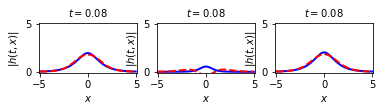

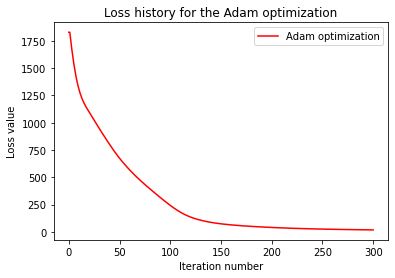

In [ ]:
 
fig, [ax1, ax2, ax3] = plt.subplots(1,3)
 
plot_slice(ax1, Exact_u,U1_pred[:, -1], idx_t1, x_star,t)
plot_slice(ax2, Exact_v,V1_pred[:, -1], idx_t1, x_star,t)
plot_slice(ax3, Exact_h,h_pred, idx_t1, x_star,t)
 
fig_loss, ax_loss = plt.subplots(1,1)
plot_Adam_history(ax_loss, loss_hist)

#dt = 0.15

Setting


In [ ]:
q = 20
layers = [2, 40, 40, 40, 40, 2*(q+1)]

idx_t0 = 0
idx_t1 = 20
dt = t[idx_t1] - t[idx_t0]

model = Schrodinger_PINN(x0, u0,v0, layers, dt, lb, ub, q)

#model.model(x0)

Training

In [ ]:
 
adam_iterations = 300     # Number of training steps 
lbfgs_max_iterations = 300 # Max iterations for lbfgs
    
loss_hist = model.train(adam_iterations, lbfgs_max_iterations)


100%|██████████| 300/300 [00:15<00:00, 19.90it/s]


Training time: 15.0807


Prediction

In [ ]:
 
U1_pred, V1_pred = model.predict(x_star)
h_pred = np.sqrt(U1_pred[:, -1:]**2 + V1_pred[:, -1:]**2)


Plotting

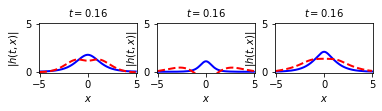

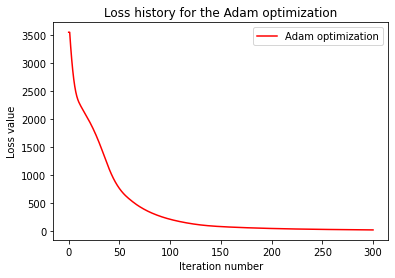

In [ ]:
 
fig, [ax1, ax2, ax3] = plt.subplots(1,3)
 
plot_slice(ax1, Exact_u,U1_pred[:, -1], idx_t1, x_star,t)
plot_slice(ax2, Exact_v,V1_pred[:, -1], idx_t1, x_star,t)
plot_slice(ax3, Exact_h,h_pred, idx_t1, x_star,t)
 
fig_loss, ax_loss = plt.subplots(1,1)
plot_Adam_history(ax_loss, loss_hist)

#Utils

Save figure

In [ ]:
 
format = 'png'
 
results = 'results.'+format
loss = 'loss_hist.'+format
 
fig.savefig(results)
fig_loss.savefig(loss)